In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('uber_cleaned.csv')
df.rename(columns = {'pickup_longitude_x': 'pickup_longitude',
                     'pickup_latitude_x': 'pickup_latitude'}, inplace = True)
df.head()

,fare_id,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_latitude_rounded,...,haversine_distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_dayofweek,pickup_dayofweek_label,fare_per_passenger,sublocality
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,40.738,...,1.683323,2015,5,7,19,52,3,Thursday,7.500000,Manhattan
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,40.728,...,2.457590,2009,7,17,20,4,4,Friday,7.700000,Manhattan
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,40.741,...,5.036377,2009,8,24,21,45,0,Monday,12.900000,Manhattan
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,40.791,...,1.661683,2009,6,26,8,22,4,Friday,1.766667,Manhattan
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,40.744,...,4.475450,2014,8,28,17,47,3,Thursday,3.200000,Queens


# Questions to answer:
## Business Performance
1. What are the peak demand hours/days?
2. Which locations generate highest revenue per trip?
3. How does fare vary by distance, time, and passenger count?

In [2]:
import plotly.express as px

# Count trips for each hour and day of week
heatmap_data = df.groupby(['pickup_dayofweek_label', 'pickup_hour']).size().reset_index(name='trip_count')

# Pivot for heatmap
heatmap_pivot = heatmap_data.pivot(index='pickup_dayofweek_label', columns='pickup_hour', values='trip_count')

# Plotly heatmap
fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Pickup Hour", y="Day of Week", color="Trip Count"),
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    aspect="auto",
    title="Uber Trips Heatmap by Hour and Day of Week"
)
fig.show()

In [3]:
# Calculate total and average revenue per pickup location (rounded coordinates for grouping)
pickup_revenue = df.groupby(['sublocality']).agg(
    avg_revenue=('fare_amount', 'mean'),
    trip_count=('fare_amount', 'count')
).reset_index()

pickup_revenue.sort_values('avg_revenue', ascending=False).head(10)

,sublocality,avg_revenue,trip_count
3,Queens,29.337320,9661
5,Staten Island,17.382308,13
0,Brooklyn,12.953525,4414
1,Chauncey,12.900000,1
6,The Bronx,12.094585,205
2,Manhattan,10.213950,181151
4,Sobral,8.900000,1


In [9]:
import plotly.graph_objects as go

# Get top 10 locations for visualization
top_locations = pickup_revenue.sort_values('avg_revenue', ascending=False).head(10)

# Bar chart for average revenue
fig = go.Figure(data=[
    go.Bar(x=top_locations['sublocality'], 
           y=top_locations['avg_revenue'],
           marker_color='orange')
])

fig.update_layout(
    title='Average Revenue per Trip by Location',
    xaxis_title='Pickup Location',
    yaxis_title='Average Revenue ($)',
    xaxis_tickangle=45
)

fig.show()

In [5]:
df.columns

Index(['fare_id', 'key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'pickup_latitude_rounded',
       'pickup_longitude_rounded', 'haversine_distance', 'pickup_year',
       'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_minute',
       'pickup_dayofweek', 'pickup_dayofweek_label', 'fare_per_passenger',
       'sublocality'],
      dtype='object')

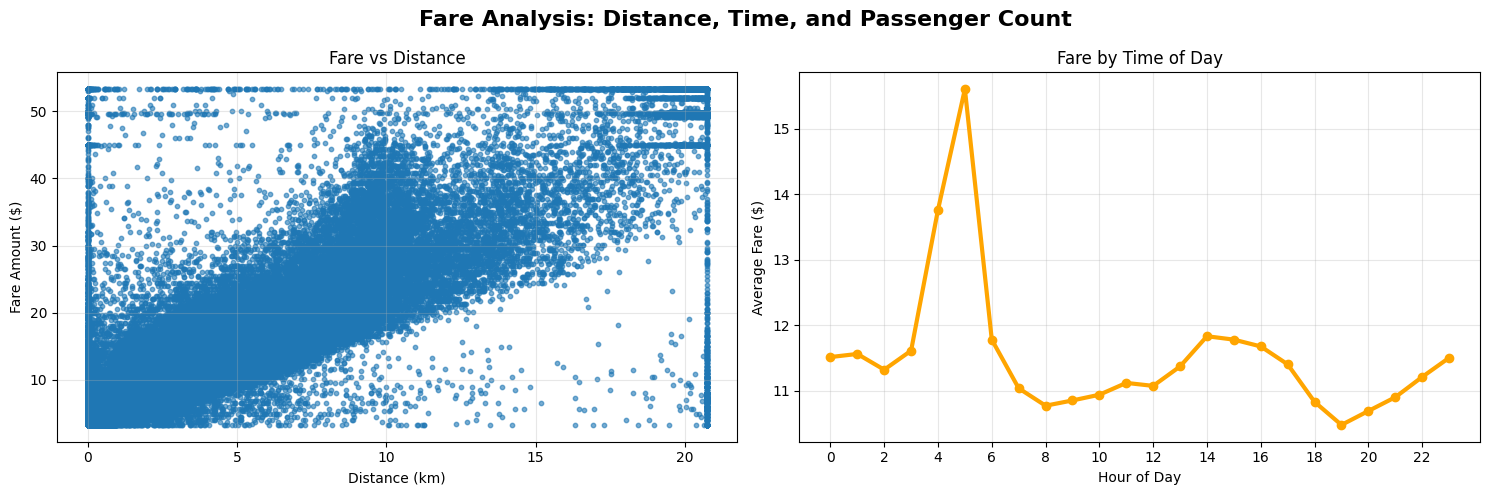

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Fare Analysis: Distance, Time, and Passenger Count', fontsize=16, fontweight='bold')

# Fare vs Distance
axes[0].scatter(df['haversine_distance'], df['fare_amount'], alpha=0.6, s=10)
axes[0].set_xlabel('Distance (km)')
axes[0].set_ylabel('Fare Amount ($)')
axes[0].set_title('Fare vs Distance')
axes[0].grid(True, alpha=0.3)

# Fare by Time of Day
hourly_fare = df.groupby('pickup_hour')['fare_amount'].mean().reset_index()
axes[1].plot(hourly_fare['pickup_hour'], hourly_fare['fare_amount'], 
                marker='o', linewidth=3, color='orange', markersize=6)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Average Fare ($)')
axes[1].set_title('Fare by Time of Day')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

In [ ]:
# Additional detailed analysis
print("\n=== FARE VARIATION ANALYSIS ===")

# Correlation analysis
print("\n1. CORRELATION WITH DISTANCE:")
distance_corr = df[['fare_amount', 'haversine_distance']].corr().iloc[0,1]
print(f"Fare-Distance Correlation: {distance_corr:.3f}")

# Time-based analysis
print("\n2. FARE BY TIME PERIODS:")
df['time_period'] = pd.cut(df['pickup_hour'], 
                          bins=[0, 6, 12, 18, 24], 
                          labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                          include_lowest=True)
time_fare = df.groupby('time_period')['fare_amount'].agg(['mean', 'std', 'count'])
print(time_fare)

# Passenger count analysis
print("\n3. FARE BY PASSENGER COUNT:")
passenger_analysis = df.groupby('passenger_count').agg({
    'fare_amount': ['mean', 'std', 'count'],
    'haversine_distance': ['mean', 'std', 'count']
}).round(2)
print(passenger_analysis)

# Per-passenger fare
df['fare_per_passenger'] = df['fare_amount'] / df['passenger_count']
print("\n4. FARE PER PASSENGER:")
per_passenger_fare = df.groupby('passenger_count')['fare_per_passenger'].mean()
print(per_passenger_fare)

# Distance categories analysis
print("\n5. FARE BY DISTANCE CATEGORIES:")
df['distance_category'] = pd.cut(df['haversine_distance'], 
                                bins=[0, 2, 5, 10, float('inf')], 
                                labels=['Short (<2km)', 'Medium (2-5km)', 'Long (5-10km)', 'Very Long (>10km)'])
distance_fare = df.groupby('distance_category')['fare_amount'].agg(['mean', 'median', 'count'])
print(distance_fare)


=== FARE VARIATION ANALYSIS ===

1. CORRELATION WITH DISTANCE:
Fare-Distance Correlation: 0.844

2. FARE BY TIME PERIODS:
                  mean       std  count
time_period                            
Night        11.988305  9.460077  29901
Morning      10.965140  8.846408  53935
Afternoon    11.450096  9.676981  59530
Evening      10.927325  8.281019  56634

3. FARE BY PASSENGER COUNT:
                fare_amount               haversine_distance              
                       mean   std   count               mean   std   count
passenger_count                                                           
1                     11.13  8.93  139134               3.25  3.57  139134
2                     11.67  9.52   29428               3.44  3.82   29428
3                     11.38  9.14    8881               3.32  3.67    8881
4                     11.54  9.35    4276               3.36  3.74    4276
5                     11.15  8.94   14009               3.27  3.60   14009
6       

/tmp/ipykernel_6919/162941079.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_6919/162941079.py:37: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Pricing Insights
4. Is there dynamic pricing evidence? (fare/km variance by hour)
5. Are there fare anomalies or outliers to investigate?
6. How does passenger count affect per-passenger pricing?

In [26]:
from scipy import stats

print("4. DYNAMIC PRICING ANALYSIS:")
print("-" * 40)
# Calculate fare per km
df['fare_per_km'] = df['fare_amount'] / df['haversine_distance']

# Remove infinite and extremely high values
df_clean = df[(df['fare_per_km'] < 50) & (df['fare_per_km'] > 0)].copy()

# Hourly fare per km analysis
hourly_pricing = df_clean.groupby('pickup_hour')['fare_per_km'].agg(['mean', 'std', 'count']).round(3)
print("Fare per km by hour:")
print(hourly_pricing)

# Calculate coefficient of variation to measure pricing variance
hourly_pricing['cv'] = (hourly_pricing['std'] / hourly_pricing['mean']) * 100
print(f"\nCoefficient of Variation by hour:")
print(hourly_pricing[['cv']])

# Statistical test for significant differences
hour_groups = [df_clean[df_clean['pickup_hour'] == h]['fare_per_km'].values for h in range(24)]
f_stat, p_value = stats.f_oneway(*hour_groups)
print(f"\nANOVA test for hourly differences:")
print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.6f}")

if p_value < 0.05:
    print("✓ Significant evidence of dynamic pricing (p < 0.05)")
else:
    print("✗ No significant evidence of dynamic pricing (p >= 0.05)")

4. DYNAMIC PRICING ANALYSIS:
----------------------------------------
Fare per km by hour:
              mean    std  count
pickup_hour                     
0            3.936  2.456   7587
1            3.899  2.831   5687
2            3.923  2.906   4249
3            3.948  3.339   3116
4            3.809  3.346   2273
5            3.599  2.647   1879
6            3.713  2.385   3981
7            4.066  2.518   6976
8            4.553  2.638   8790
9            4.778  2.931   9020
10           4.710  2.910   8662
11           4.772  2.807   9069
12           4.937  3.207   9601
13           4.810  2.918   9665
14           4.770  3.012   9446
15           4.738  3.079   9255
16           4.592  2.905   7991
17           4.615  2.939   9397
18           4.599  2.899  11655
19           4.435  2.624  12161
20           4.216  2.677  11371
21           4.097  2.692  11067
22           3.998  2.531  10658
23           4.024  2.624   9443

Coefficient of Variation by hour:
                

In [36]:
print("\n\n5. FARE ANOMALIES AND OUTLIERS:")
print("-" * 40)

# Statistical outlier detection using IQR method
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['fare_amount'] < lower_bound) | (df['fare_amount'] > upper_bound)]
print(f"Total outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.1f}% of data)")

# Fare anomalies by category
print("\nOutlier categories:")
print(f"Negative fares: {len(df[df['fare_amount'] < 0])}")
print(f"Zero fares: {len(df[df['fare_amount'] == 0])}")
print(f"Extremely high fares (>$100): {len(df[df['fare_amount'] > 100])}")
print(f"Very low fare per km (<$1/km): {len(df_clean[df_clean['fare_per_km'] < 1]) / len(df_clean) * 100:.1f}% Rides")
print(f"Very high fare per km (>$20/km): {len(df_clean[df_clean['fare_per_km'] > 20]) / len(df_clean) * 100:.1f}% Rides")

# Top 10 highest and lowest fares
print("\nTop 10 highest fares:")
print(df.nlargest(10, 'fare_amount')[['fare_amount', 'haversine_distance', 'fare_per_km', 'pickup_hour']])

print("\nTop 10 lowest positive fares:")
print(df[df['fare_amount'] > 0].nsmallest(10, 'fare_amount')[['fare_amount', 'haversine_distance', 'fare_per_km', 'pickup_hour']])




5. FARE ANOMALIES AND OUTLIERS:
----------------------------------------
Total outliers detected: 17156 (8.6% of data)

Outlier categories:
Negative fares: 0
Zero fares: 0
Extremely high fares (>$100): 0
Very low fare per km (<$1/km): 0.4% Rides
Very high fare per km (>$20/km): 0.5% Rides

Top 10 highest fares:
      fare_amount  haversine_distance  fare_per_km  pickup_hour
48           53.3            0.000000          inf           22
401          53.3           20.109038     2.650549           14
570          53.3           20.722016     2.572144            9
610          53.3           20.722016     2.572144           16
880          53.3           20.722016     2.572144           15
966          53.3           19.491556     2.734517           10
985          53.3           20.722016     2.572144           17
1043         53.3           20.722016     2.572144           21
1529         53.3           19.757357     2.697729           12
1569         53.3           20.086848     2.6

In [ ]:
print("\n\n6. PASSENGER COUNT PRICING ANALYSIS:")
print("-" * 40)

# Per-passenger fare analysis
passenger_pricing = df.groupby('passenger_count').agg({
    'fare_amount': ['mean', 'median', 'std', 'count'],
    'fare_per_passenger': ['mean', 'median', 'std'],
    'haversine_distance': ['mean']
}).round(2)

# Pricing by Passenger count
passenger_pricing



6. PASSENGER COUNT PRICING ANALYSIS:
----------------------------------------


fare_amount                      fare_per_passenger         \
                       mean median   std   count               mean median   
passenger_count                                                              
1                     11.13    8.5  8.93  139134              11.13   8.50   
2                     11.67    8.5  9.52   29428               5.83   4.25   
3                     11.38    8.5  9.14    8881               3.79   2.83   
4                     11.54    8.5  9.35    4276               2.88   2.12   
5                     11.15    8.5  8.94   14009               2.23   1.70   
6                     12.06    9.0  9.55    4272               2.01   1.50   

                      haversine_distance  
                  std               mean  
passenger_count                           
1                8.93               3.25  
2                4.76               3.44  
3                3.05               3.32  
4                2.34               3.36  
5                1.79               3.27  
6                1.59               3.40

In [44]:
# Test for significant differences in per-passenger pricing
passenger_groups = [df[df['passenger_count'] == p]['fare_per_passenger'].values 
                   for p in df['passenger_count'].unique() if not pd.isna(p)]
f_stat_passenger, p_value_passenger = stats.f_oneway(*passenger_groups)

print(f"\nANOVA test for per-passenger fare differences:")
print(f"F-statistic: {f_stat_passenger:.3f}, p-value: {p_value_passenger:.6f}")

# Calculate pricing efficiency
print("\nPricing efficiency analysis:")
for pc in sorted(df['passenger_count'].unique()):
    if not pd.isna(pc) and pc > 0:
        subset = df[df['passenger_count'] == pc]
        avg_total_fare = subset['fare_amount'].mean()
        avg_per_passenger = subset['fare_per_passenger'].mean()
        print(f"Passenger Count {int(pc)}: Total ${avg_total_fare:.2f}, Per-passenger ${avg_per_passenger:.2f}")


ANOVA test for per-passenger fare differences:
F-statistic: 7314.513, p-value: 0.000000

Pricing efficiency analysis:
Passenger Count 1: Total $11.13, Per-passenger $11.13
Passenger Count 2: Total $11.67, Per-passenger $5.83
Passenger Count 3: Total $11.38, Per-passenger $3.79
Passenger Count 4: Total $11.54, Per-passenger $2.88
Passenger Count 5: Total $11.15, Per-passenger $2.23
Passenger Count 6: Total $12.06, Per-passenger $2.01


/tmp/ipykernel_6919/1335567392.py:27: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



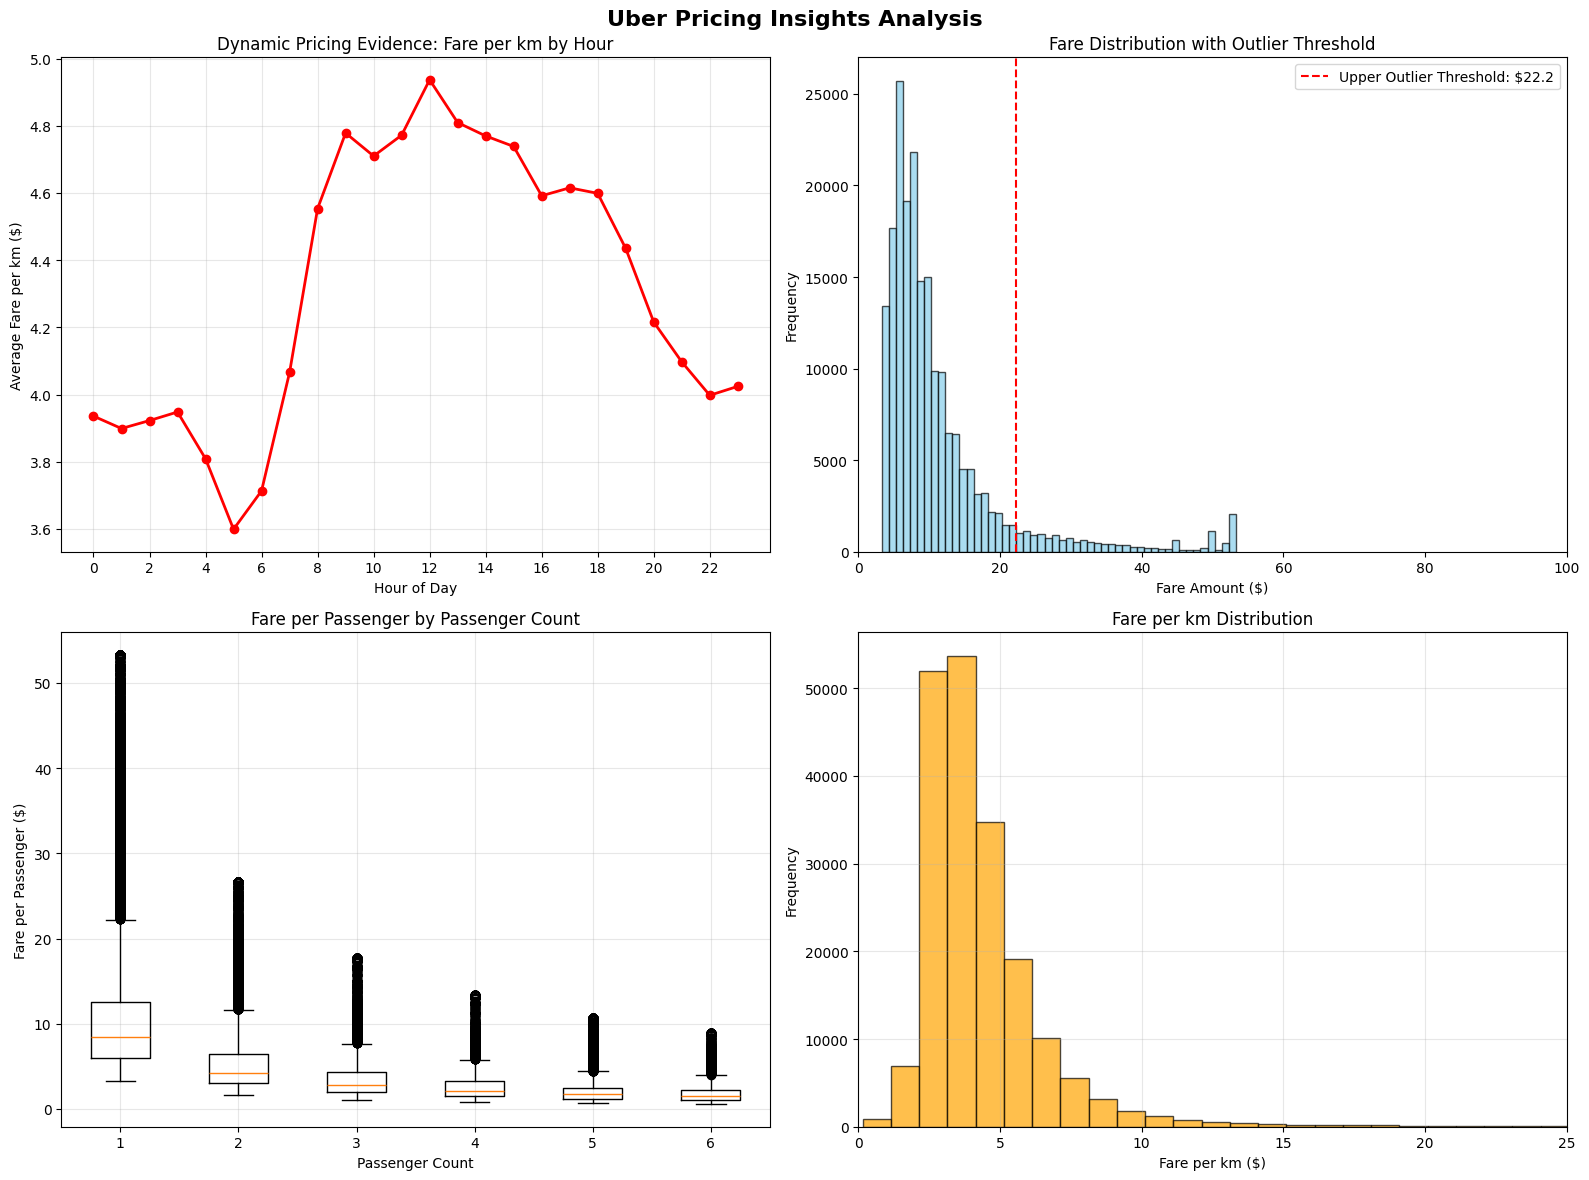


PRICING INSIGHTS SUMMARY:
• Dynamic Pricing: Evidence found
• Outliers: 8.6% of trips are statistical outliers
• Peak fare/km hour: 12:00 ($4.94/km)
• Lowest fare/km hour: 5:00 ($3.60/km)
• Per-passenger pricing varies significantly: Yes


In [45]:
# VISUALIZATION OF PRICING INSIGHTS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Uber Pricing Insights Analysis', fontsize=16, fontweight='bold')

# 1. Fare per km by hour (Dynamic Pricing)
hourly_avg = df_clean.groupby('pickup_hour')['fare_per_km'].mean()
axes[0,0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6, color='red')
axes[0,0].set_title('Dynamic Pricing Evidence: Fare per km by Hour')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Average Fare per km ($)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xticks(range(0, 24, 2))

# 2. Fare distribution with outliers
axes[0,1].hist(df['fare_amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(upper_bound, color='red', linestyle='--', label=f'Upper Outlier Threshold: ${upper_bound:.1f}')
axes[0,1].set_title('Fare Distribution with Outlier Threshold')
axes[0,1].set_xlabel('Fare Amount ($)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].set_xlim(0, 100)  # Focus on main distribution

# 3. Box plot of fare per passenger by passenger count
passenger_data = [df[df['passenger_count'] == pc]['fare_per_passenger'].values 
                 for pc in sorted(df['passenger_count'].unique()) if not pd.isna(pc)]
passenger_labels = [f'{int(pc)}' for pc in sorted(df['passenger_count'].unique()) if not pd.isna(pc)]
axes[1,0].boxplot(passenger_data, labels=passenger_labels)
axes[1,0].set_title('Fare per Passenger by Passenger Count')
axes[1,0].set_xlabel('Passenger Count')
axes[1,0].set_ylabel('Fare per Passenger ($)')
axes[1,0].grid(True, alpha=0.3)

# 4. Fare per km distribution
axes[1,1].hist(df_clean['fare_per_km'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_title('Fare per km Distribution')
axes[1,1].set_xlabel('Fare per km ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].set_xlim(0, 25)

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*60)
print("PRICING INSIGHTS SUMMARY:")
print("="*60)
print(f"• Dynamic Pricing: {'Evidence found' if p_value < 0.05 else 'No clear evidence'}")
print(f"• Outliers: {len(outliers)/len(df)*100:.1f}% of trips are statistical outliers")
print(f"• Peak fare/km hour: {hourly_avg.idxmax()}:00 (${hourly_avg.max():.2f}/km)")
print(f"• Lowest fare/km hour: {hourly_avg.idxmin()}:00 (${hourly_avg.min():.2f}/km)")
print(f"• Per-passenger pricing varies significantly: {'Yes' if p_value_passenger < 0.05 else 'No'}")

## Operational Patterns
8. What's the geographic distribution of pickups?
9. Are there seasonal trends in ridership/fares?
10. Which trip categories (short/long) dominate?